# Zillow Clustering Project - Final Notebook
## Executive Summary
### Goal: Identify drivers of prediction error, build models to predict the error
### Findings: Analyzed features do not drive prediction error, models do not predict error accurately
### Recommendations: Continue to build features using latitude and longitude to improve predictions

# Wrangling
## Bottom Line Up Front
1. Acquired data from Codeup's 'zillow' database
2. **MVP columns**: Parcel.ID, County, Latitude, Longitude, Home.Value, Baths, Beds, Finished.Area, and Prediction.Error (target)
3. Dropped all nulls (low proportion of nulls)
4. Removed outliers using IQR
    * did not remove outliers from target (Prediction.Error)
5. Split data into train, validate, test
6. Isolated target (Prediction.Error) from each data split
7. Scaled numeric features
8. Created exploration dataframe that includes scaled/unscaled data and target
9. **After Feature Engineering**: 
    * Added southern coastline lat/longs as feature **is_coastal** (one-hot encoded)
    * Added coordinate boundaries for areas having low Prediction.Error as feature **cool_places** (one-hot encoded)

In [1]:
### Imports ###
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

import wrangle
import modeling

## Implementation

In [2]:
### Wrangle ###
df, X_train_exp,\
X_train, y_train,\
X_validate, y_validate,\
X_test, y_test = wrangle.wrangle_zillow_MVP()

X_train_exp.head(3)

,Parcel.ID,County,Latitude,Longitude,Home.Value,Baths,Beds,Finished.Area,is_coastal,cool_places,Prediction.Error,Home.Value.Scaled,Baths.Scaled,Beds.Scaled,Finished.Area.Scaled,Is.Coastal.Scaled,Is.Cool.Place.Scaled
9816,14433972,Orange,33494840,-117693964,1032894,3.5,3.0,2841,False,False,0.064047,2.545324,1.926880,-0.261993,1.894494,0.152861,0.508689
40848,14037584,Orange,33742714,-118017115,59427,2.0,4.0,1182,False,False,0.012524,-1.244041,-0.133840,1.008879,-0.854941,0.152861,0.508689
38048,11693178,LA,33992973,-118287389,238563,1.0,3.0,2628,False,False,0.098879,-0.546727,-1.507654,-0.261993,1.541492,0.152861,0.508689


# Exploring

## Bottom Line Up Front
1. Plotted distributions of each variable
2. Plotted **correlation heatmap** for features (included)
3. Plotted **latitude/longitude against high-error property predictions** (included)
4. Noticed southern coastline properties have higher error (plot included)
    * Used feature engineering to **mark properties as coastline properties** or not coastline properties
5. Noticed some latitude/longitudes were prone to higher error (plot included)
    * Used feature engineering to **mark coordinate boundaries, identify properties** within the boundaries
6. **Used clustering** against Home.Value, Baths, Beds, Finished.Area, and Is.Coastal features (plot included)

## Implementation
### Latitude/Longitude Distribution

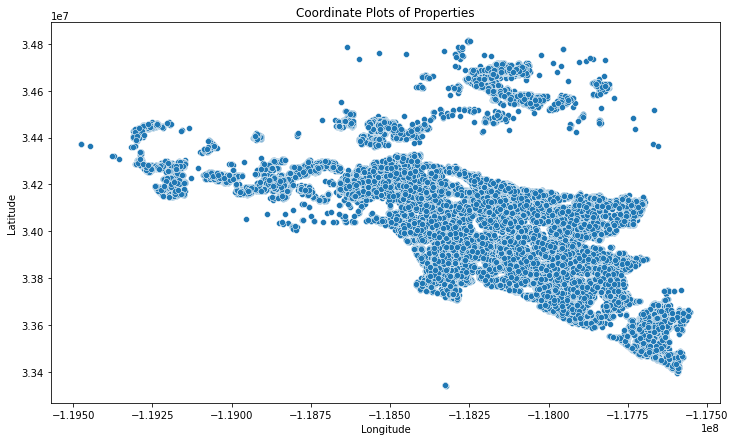

In [3]:
plt.figure(figsize=(12,7))
sns.scatterplot(df.Longitude, df.Latitude)
plt.title('Coordinate Plots of Properties')
plt.show()

### Correlation Heatmap

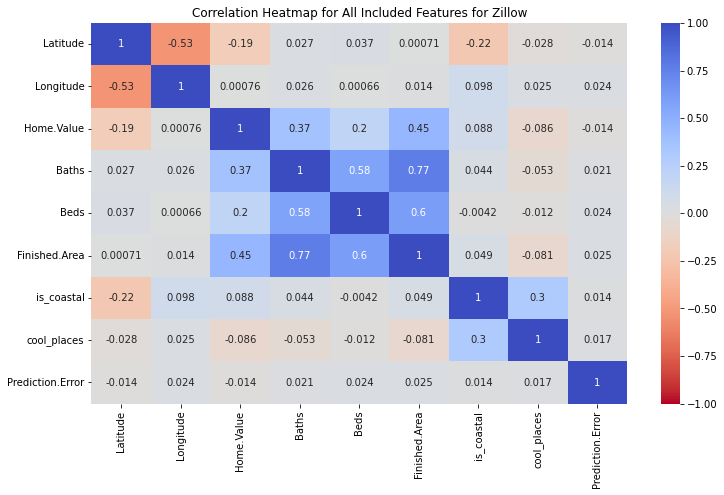

In [4]:
plt.figure(figsize=(12,7))
column_list_here = ['Home.Value.Scaled', 'Baths.Scaled', 'Beds.Scaled',
                    'Finished.Area.Scaled', 'Is.Coastal.Scaled', 'Is.Cool.Place.Scaled']
sns.heatmap(X_train_exp.drop(columns=column_list_here).corr(), cmap='coolwarm_r', vmin=-1, vmax=1, annot=True)
plt.title('Correlation Heatmap for All Included Features for Zillow')
plt.show()

### High-Error Properties by Latitude/Longitude

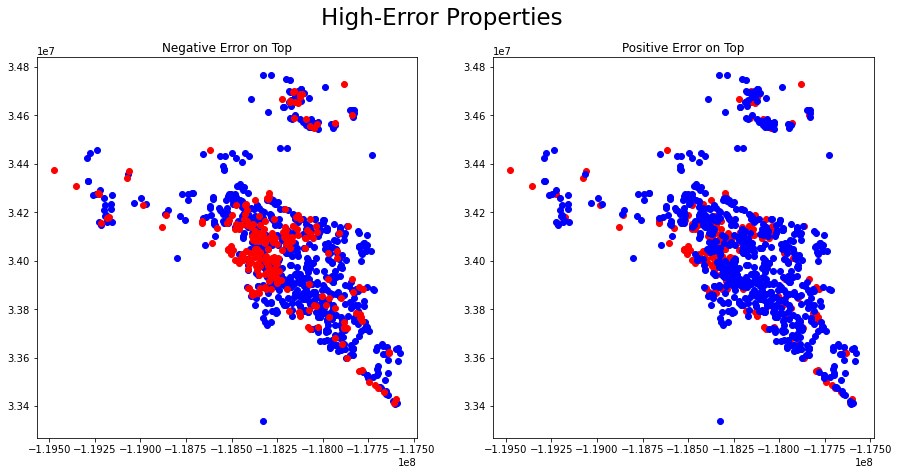

In [5]:
plt.figure(figsize=(15,7))
plt.subplot(121)
plt.scatter(X_train_exp[X_train_exp['Prediction.Error'] > 0.3].Longitude, X_train_exp[X_train_exp['Prediction.Error'] > 0.3].Latitude, c='blue')
plt.scatter(X_train_exp[X_train_exp['Prediction.Error'] < -0.3].Longitude, X_train_exp[X_train_exp['Prediction.Error'] < -0.3].Latitude, c='red')
plt.title('Negative Error on Top')

plt.subplot(122)
plt.scatter(X_train_exp[X_train_exp['Prediction.Error'] < -0.3].Longitude, X_train_exp[X_train_exp['Prediction.Error'] < -0.3].Latitude, c='red')
plt.scatter(X_train_exp[X_train_exp['Prediction.Error'] > 0.3].Longitude, X_train_exp[X_train_exp['Prediction.Error'] > 0.3].Latitude, c='blue')
plt.title('Positive Error on Top')

plt.suptitle('High-Error Properties', size=23)
plt.show()

### Coastline Properties
#### Coastline Property Identification

In [6]:
X_train_exp['relaxed_lat'] = 2 * round(X_train_exp['Latitude'] / 2000000, 4)
X_train_exp['relaxed_long'] = 2 * round(X_train_exp['Longitude'] / 2000000, 4)
print('Number of rows:', len(X_train_exp))
print('Unique latitudes:', len(X_train_exp['relaxed_lat'].unique()))
print('Unique longitudes:', len(X_train_exp['relaxed_long'].unique()))

Number of rows: 27504
Unique latitudes: 5482
Unique longitudes: 6754


In [7]:
latlong_dict = dict(X_train_exp.groupby('relaxed_lat').Longitude.min())
longlat_dict = dict(X_train_exp.groupby('relaxed_long').Latitude.min())

In [8]:
X_train_exp['is_coastal_horizontal'] = ((X_train_exp['relaxed_lat'] <= 33.9) & 
                              (X_train_exp['relaxed_lat'].apply(lambda x: latlong_dict.get(x)) == X_train_exp['Longitude']))
    
X_train_exp['is_coastal_vertical'] = ((X_train_exp['relaxed_long'] >= -118.40) & 
                            (X_train_exp['relaxed_long'].apply(lambda x: longlat_dict.get(x)) == X_train_exp['Latitude']))

print('Horizontal Mean:', X_train_exp['is_coastal_horizontal'].mean())
print('Horizontal Error:', X_train_exp.groupby('is_coastal_horizontal')['Prediction.Error'].mean())
print('Vertical Mean:', X_train_exp['is_coastal_vertical'].mean())
print('Vertical Error:', X_train_exp.groupby('is_coastal_vertical')['Prediction.Error'].mean())

Horizontal Mean: 0.07678883071553229
Horizontal Error: is_coastal_horizontal
False    0.016337
True     0.025994
Name: Prediction.Error, dtype: float64
Vertical Mean: 0.14819662594531705
Vertical Error: is_coastal_vertical
False    0.016544
True     0.020154
Name: Prediction.Error, dtype: float64


In [9]:
X_train_exp['is_coastal'] = X_train_exp['is_coastal_vertical'] & X_train_exp['is_coastal_horizontal']
print('Mean:', X_train_exp['is_coastal'].mean())
print('Error:', X_train_exp.groupby('is_coastal')['Prediction.Error'].mean())

Mean: 0.04173938336242001
Error: is_coastal
False    0.016723
True     0.025231
Name: Prediction.Error, dtype: float64


#### Coastal Properties Plot by Latitude/Longitude

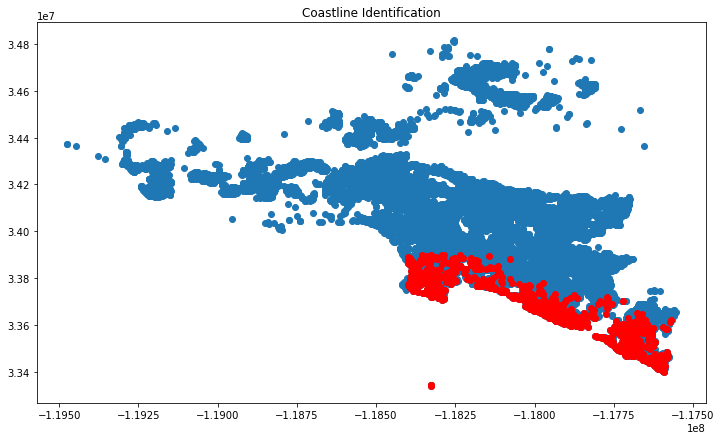

In [10]:
plt.figure(figsize=(12,7))
plt.scatter(X_train_exp.Longitude, X_train_exp.Latitude)
plt.scatter(X_train_exp[X_train_exp.is_coastal].Longitude, X_train_exp[X_train_exp.is_coastal].Latitude, c='red')
plt.title('Coastline Identification')
plt.show()

#### Coastal Property Hypothesis Testing
$H_0$: On average, coastal properties are *not* predicted lower than actual cost more often than non-coastal properties.

$H_a$: On average, coastal properties are predicted lower than actual cost more often than non-coastal properties.

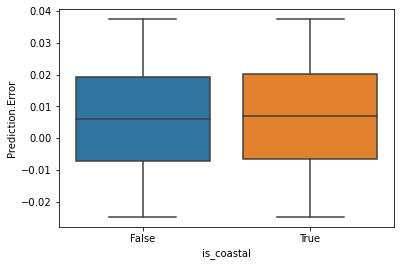

In [11]:
q1, q3 = X_train_exp['Prediction.Error'].quantile([0.25, 0.75])
mask = (X_train_exp['Prediction.Error'] > q1) & (X_train_exp['Prediction.Error'] < q3)
sns.boxplot(X_train_exp[mask]['is_coastal'], X_train_exp[mask]['Prediction.Error'])
plt.show()

In [12]:
# Set alpha
alpha = .05
# Run test
t, p = stats.mannwhitneyu(df[df.is_coastal]['Prediction.Error'], 
                          df[df.is_coastal == False]['Prediction.Error'],
                          alternative='greater')

# Print findings
if p < alpha:
    print("We reject the null hypothesis.")
else:
    print("We accept the null hypothesis.")

We reject the null hypothesis.


### High-Error Property Boundaries

In [13]:
X_train_exp['square'] = (X_train_exp.Latitude > 33850000) & (X_train_exp.Latitude < 34000000) & (X_train_exp.Longitude > -118200000) & (X_train_exp.Longitude < -118000000)
X_train_exp['rectangle'] = (X_train_exp.Latitude > 33950000) & (X_train_exp.Latitude < 34070000) & (X_train_exp.Longitude > -118150000) & (X_train_exp.Longitude < -117650000)
X_train_exp['diagonal_0'] = (X_train_exp.Latitude > 34150000) & (X_train_exp.Latitude < 34200000) & (X_train_exp.Longitude > -118650000) & (X_train_exp.Longitude < -118560000)
X_train_exp['diagonal_1'] = (X_train_exp.Latitude > 34190000) & (X_train_exp.Latitude < 34210000) & (X_train_exp.Longitude > -118650000) & (X_train_exp.Longitude < -118480000)
X_train_exp['diagonal_2'] = (X_train_exp.Latitude > 34220000) & (X_train_exp.Latitude < 34350000) & (X_train_exp.Longitude > -118650000) & (X_train_exp.Longitude < -118340000)

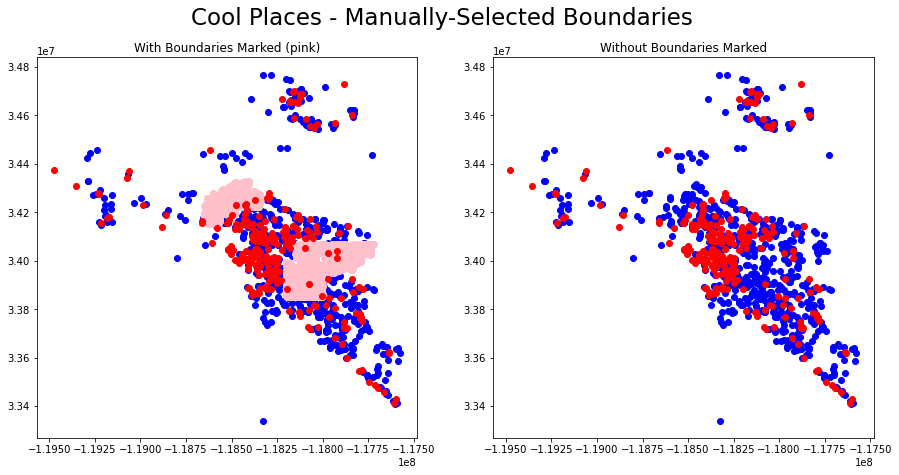

In [14]:
plt.figure(figsize=(15,7))
plt.subplot(121)
plt.scatter(X_train_exp[X_train_exp['Prediction.Error'] > 0.3].Longitude, X_train_exp[X_train_exp['Prediction.Error'] > 0.3].Latitude, c='blue')
plt.scatter(X_train_exp[X_train_exp['square']].Longitude, X_train_exp[X_train_exp['square']].Latitude, c='pink')
plt.scatter(X_train_exp[X_train_exp['rectangle']].Longitude, X_train_exp[X_train_exp['rectangle']].Latitude, c='pink')
plt.scatter(X_train_exp[X_train_exp['diagonal_0']].Longitude, X_train_exp[X_train_exp['diagonal_0']].Latitude, c='pink')
plt.scatter(X_train_exp[X_train_exp['diagonal_1']].Longitude, X_train_exp[X_train_exp['diagonal_1']].Latitude, c='pink')
plt.scatter(X_train_exp[X_train_exp['diagonal_2']].Longitude, X_train_exp[X_train_exp['diagonal_2']].Latitude, c='pink')
plt.scatter(X_train_exp[X_train_exp['Prediction.Error'] < -0.3].Longitude, X_train_exp[X_train_exp['Prediction.Error'] < -0.3].Latitude, c='red')
plt.title('With Boundaries Marked (pink)')

plt.subplot(122)
plt.scatter(X_train_exp[X_train_exp['Prediction.Error'] > 0.3].Longitude, X_train_exp[X_train_exp['Prediction.Error'] > 0.3].Latitude, c='blue')
plt.scatter(X_train_exp[X_train_exp['Prediction.Error'] < -0.3].Longitude, X_train_exp[X_train_exp['Prediction.Error'] < -0.3].Latitude, c='red')
plt.title('Without Boundaries Marked')

plt.suptitle('Cool Places - Manually-Selected Boundaries', size=23)
plt.show()

In [15]:
X_train_exp['cool_places'] = (X_train_exp['is_coastal'] | X_train_exp['square'] | X_train_exp['rectangle'] | 
                     X_train_exp['diagonal_0'] | X_train_exp['diagonal_1'] | X_train_exp['diagonal_2'])

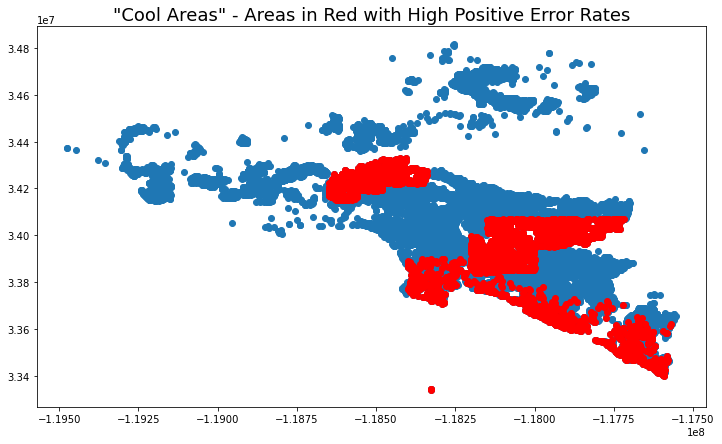

In [16]:
plt.figure(figsize=(12,7))
plt.scatter(X_train_exp.Longitude, X_train_exp.Latitude)
plt.scatter(X_train_exp[X_train_exp.cool_places].Longitude, X_train_exp[X_train_exp.cool_places].Latitude, c='red')
plt.title('"Cool Areas" - Areas in Red with High Positive Error Rates', size=18)
plt.show()

In [17]:
print("% of total properties:", X_train_exp.cool_places.mean())
X_train_exp.groupby('cool_places')['Prediction.Error'].mean()

% of total properties: 0.22429464805119256


cool_places
False    0.015578
True     0.022267
Name: Prediction.Error, dtype: float64

In [18]:
X_train_exp = X_train_exp.drop(columns=['square','rectangle',
                 'diagonal_0','diagonal_1','diagonal_2',
                 'relaxed_lat','relaxed_long',
                 'is_coastal_horizontal',
                 'is_coastal_vertical',])

X_train_exp.head(3)

,Parcel.ID,County,Latitude,Longitude,Home.Value,Baths,Beds,Finished.Area,is_coastal,cool_places,Prediction.Error,Home.Value.Scaled,Baths.Scaled,Beds.Scaled,Finished.Area.Scaled,Is.Coastal.Scaled,Is.Cool.Place.Scaled
9816,14433972,Orange,33494840,-117693964,1032894,3.5,3.0,2841,False,False,0.064047,2.545324,1.926880,-0.261993,1.894494,0.152861,0.508689
40848,14037584,Orange,33742714,-118017115,59427,2.0,4.0,1182,False,False,0.012524,-1.244041,-0.133840,1.008879,-0.854941,0.152861,0.508689
38048,11693178,LA,33992973,-118287389,238563,1.0,3.0,2628,False,False,0.098879,-0.546727,-1.507654,-0.261993,1.541492,0.152861,0.508689


### Clustering

In [19]:
# Fresh copy of data for clustering
columns_to_scale = ['Home.Value', 'Baths', 'Beds', 'Finished.Area', 'is_coastal']
train, validate, test = wrangle.split_data(df)
X_train, y_train,\
X_validate, y_validate,\
X_test, y_test = wrangle.isolate_zillow_target('Prediction.Error', train, validate, test)
X_train.head(3)

,Parcel.ID,County,Latitude,Longitude,Home.Value,Baths,Beds,Finished.Area,is_coastal,cool_places
9816,14433972,Orange,33494840,-117693964,1032894,3.5,3.0,2841,False,False
40848,14037584,Orange,33742714,-118017115,59427,2.0,4.0,1182,False,False
38048,11693178,LA,33992973,-118287389,238563,1.0,3.0,2628,False,False


In [20]:
scaler = StandardScaler()
X_train_c0 = scaler.fit_transform(X_train[columns_to_scale])
X_train[['Home.Value.Scaled', 
        'Baths.Scaled', 
        'Beds.Scaled', 
        'Finished.Area.Scaled', 
        'Is.Coastal.Scaled']] = X_train_c0

X_validate_c0 = scaler.transform(X_validate[columns_to_scale])
X_validate[['Home.Value.Scaled', 
            'Baths.Scaled', 
            'Beds.Scaled', 
            'Finished.Area.Scaled', 
            'Is.Coastal.Scaled']] = X_validate_c0
X_test_c0 = scaler.transform(X_test[columns_to_scale])
X_test[['Home.Value.Scaled', 
        'Baths.Scaled', 
        'Beds.Scaled', 
        'Finished.Area.Scaled', 
        'Is.Coastal.Scaled']] = X_test_c0

In [21]:
kmeans_c0 = KMeans(n_clusters=5, random_state=123)
kmeans_c0.fit(X_train_c0)

KMeans(n_clusters=5, random_state=123)

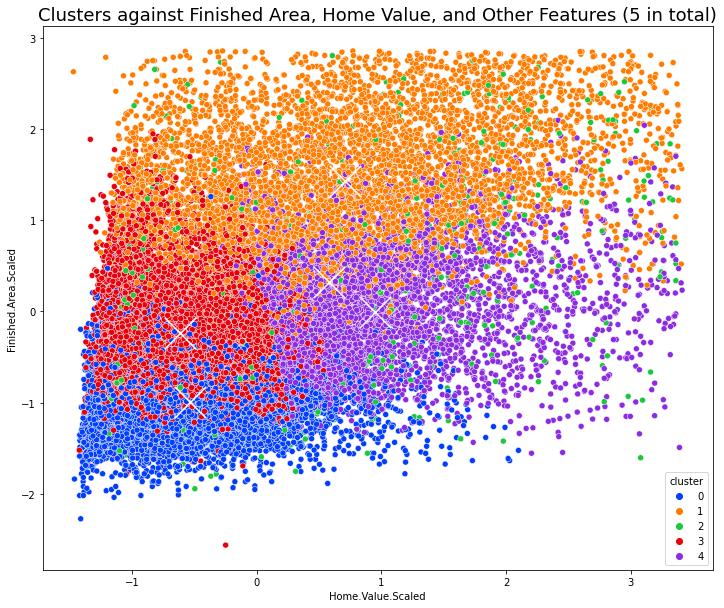

In [22]:
X_train['cluster'] = kmeans_c0.predict(X_train_c0)
centroids = X_train.groupby('cluster')['Home.Value.Scaled','Finished.Area.Scaled'].mean()
plt.figure(figsize=(12,10))
sns.scatterplot(data=X_train, x='Home.Value.Scaled', y='Finished.Area.Scaled', hue='cluster', palette='bright')
centroids.plot.scatter(x='Home.Value.Scaled', y='Finished.Area.Scaled', marker='x', s=1000, ax=plt.gca(), c='white')
plt.title('Clusters against Finished Area, Home Value, and Other Features (5 in total)', size=18)
plt.show()

In [23]:
pd.concat([X_train, y_train], axis=1).groupby('cluster')['Prediction.Error'].mean()

cluster
0    0.014929
1    0.027505
2    0.032139
3    0.017164
4    0.005693
Name: Prediction.Error, dtype: float64

In [24]:
X_train['is_cluster4'] = X_train['cluster'] == 4
arraying_cluster = [[x] for x in X_train['is_cluster4']]
X_train_c0 = np.append(X_train_c0, arraying_cluster, axis=1)

X_validate['cluster'] = kmeans_c0.predict(X_validate_c0)
X_validate['is_cluster4'] = X_validate['cluster'] == 4
arraying_cluster = [[x] for x in X_validate['is_cluster4']]
X_validate_c0 = np.append(X_validate_c0, arraying_cluster, axis=1)

X_test['cluster'] = kmeans_c0.predict(X_test_c0)
X_test['is_cluster4'] = X_test['cluster'] == 4
arraying_cluster = [[x] for x in X_test['is_cluster4']]
X_test_c0 = np.append(X_test_c0, arraying_cluster, axis=1)

# Modeling
## Bottom Line Up Front
1. Converted data into format ready for my regression_shotgun function
    * Three different approaches:
        1. Model with coastal and cluster4
        2. Model with coastal as only engineered feature
        3. Model with coastal and cool_places
    * Ran three approaches through multiple regression algorithms with varying hyperparameters
2. Called function, return results to y_train, y_validate datasets
3. Called RMSE and R^2 function to calculate baseline and all models' performance
4. Compared all models for performance increases/decreases between approaches

## Implementation
### Coastal + Cluster 4

In [25]:
y_train = y_train.rename(columns={'Prediction.Error':'actuals'})
y_validate = y_validate.rename(columns={'Prediction.Error':'actuals'})

In [26]:
y_train, y_validate = modeling.regression_shotgun(X_train_c0, y_train, X_validate_c0, y_validate)

In [27]:
running_df = modeling.y_df_RMSE_r2(y_train, y_validate)
running_df

,Model,Train_RMSE,Validate_RMSE,Train_r2,Validate_r2
0,mean_bl,0.170133,0.161659,0.000000,-2.220446e-16
1,median_bl,0.170489,0.162075,-0.004186,-5.153509e-03
2,ols_preds,0.169961,0.161403,0.002025,3.160673e-03
3,lars_0.0001_preds,0.170133,0.161659,0.000000,-2.787304e-06
4,lars_0.001_preds,0.170133,0.161659,0.000000,-2.787304e-06
5,lars_0.01_preds,0.170133,0.161659,0.000000,-2.787304e-06
6,lars_0.1_preds,0.170133,0.161659,0.000000,-2.787304e-06
7,lars_1_preds,0.170133,0.161659,0.000000,-2.787304e-06
8,lars_10_preds,0.170133,0.161659,0.000000,-2.787304e-06
9,lars_100_preds,0.170133,0.161659,0.000000,-2.787304e-06


### Coastal + Cool Places

In [28]:
df, X_train_exp,\
X_train, y_train,\
X_validate, y_validate,\
X_test, y_test = wrangle.wrangle_zillow_MVP()

X_train_exp.head(3)

,Parcel.ID,County,Latitude,Longitude,Home.Value,Baths,Beds,Finished.Area,is_coastal,cool_places,Prediction.Error,Home.Value.Scaled,Baths.Scaled,Beds.Scaled,Finished.Area.Scaled,Is.Coastal.Scaled,Is.Cool.Place.Scaled
9816,14433972,Orange,33494840,-117693964,1032894,3.5,3.0,2841,False,False,0.064047,2.545324,1.926880,-0.261993,1.894494,0.152861,0.508689
40848,14037584,Orange,33742714,-118017115,59427,2.0,4.0,1182,False,False,0.012524,-1.244041,-0.133840,1.008879,-0.854941,0.152861,0.508689
38048,11693178,LA,33992973,-118287389,238563,1.0,3.0,2628,False,False,0.098879,-0.546727,-1.507654,-0.261993,1.541492,0.152861,0.508689


In [29]:
y_train = y_train.rename(columns={'Prediction.Error':'actuals'})
y_validate = y_validate.rename(columns={'Prediction.Error':'actuals'})

In [30]:
# With cool_places feature
y_train, y_validate = modeling.regression_shotgun(X_train, 
                                                  y_train, 
                                                  X_validate, 
                                                  y_validate)

In [31]:
running_df = modeling.y_df_RMSE_r2(y_train, y_validate)
running_df

,Model,Train_RMSE,Validate_RMSE,Train_r2,Validate_r2
0,mean_bl,0.170133,0.161659,0.000000,-2.220446e-16
1,median_bl,0.170489,0.162075,-0.004186,-5.153509e-03
2,ols_preds,0.169972,0.161378,0.001885,3.472602e-03
3,lars_0.0001_preds,0.170133,0.161659,0.000000,-2.787304e-06
4,lars_0.001_preds,0.170133,0.161659,0.000000,-2.787304e-06
5,lars_0.01_preds,0.170133,0.161659,0.000000,-2.787304e-06
6,lars_0.1_preds,0.170133,0.161659,0.000000,-2.787304e-06
7,lars_1_preds,0.170133,0.161659,0.000000,-2.787304e-06
8,lars_10_preds,0.170133,0.161659,0.000000,-2.787304e-06
9,lars_100_preds,0.170133,0.161659,0.000000,-2.787304e-06


### Coastal Only

In [32]:
# Coastal Only
y_train2, y_validate2 = modeling.regression_shotgun(X_train[:,(0,1,2,3,4)], 
                                                    y_train, 
                                                    X_validate[:,(0,1,2,3,4)], 
                                                    y_validate)

In [33]:
running_df2 = modeling.y_df_RMSE_r2(y_train2, y_validate2)
running_df2

,Model,Train_RMSE,Validate_RMSE,Train_r2,Validate_r2
0,mean_bl,0.170133,0.161659,0.000000,-2.220446e-16
1,median_bl,0.170489,0.162075,-0.004186,-5.153509e-03
2,ols_preds,0.169987,0.161429,0.001712,2.848242e-03
3,lars_0.0001_preds,0.170133,0.161659,0.000000,-2.787304e-06
4,lars_0.001_preds,0.170133,0.161659,0.000000,-2.787304e-06
5,lars_0.01_preds,0.170133,0.161659,0.000000,-2.787304e-06
6,lars_0.1_preds,0.170133,0.161659,0.000000,-2.787304e-06
7,lars_1_preds,0.170133,0.161659,0.000000,-2.787304e-06
8,lars_10_preds,0.170133,0.161659,0.000000,-2.787304e-06
9,lars_100_preds,0.170133,0.161659,0.000000,-2.787304e-06


## Results

### Specific
- **Baseline Best Model**: Mean
    * train RMSE: 0.1701, validate RMSE: 0.1616
- **Coastal + Cluster 4 Best Model**: OLS
    * train RMSE: 0.1699, validate RMSE: 0.1614, train_r2: 0.20%, val_r2 = 0.32%
- **Coastal + Cool Places Best Model**: OLS
    * train RMSE: 0.1699, validate RMSE: 0.1614, train_r2: 0.19%, **val_r2 = 0.35%**
- **Coastal Only Best Model**: OLS
    * train RMSE: 0.1699, validate RMSE: 0.1614, train_r2: 0.17%, val_r2 = 0.28%

### Overall
The Coastal + Cool Places approach, using OLS, performed best on out-of-sample data, but **all models performed poorly**.

# Conclusion

## Identifying coordinate boundaries for high error rate properties will improve model performance when predicting error.

## More work may identify more coordinate boundaries.